In [1]:
import os as os
import sys as sys
import re as re
import pandas as pd
import numpy as np
import json as json
import pickle
import urllib as urllib
import zlib as zlib
import base64 as base64
from requests import Request, Session
import requests
from numpy import trapz
import itertools
import zlib as zlib
import base64 as base64
import pickle
import pathlib
from tqdm import tqdm
from datetime import datetime
import time
import copy
import random
from Bio import SeqIO
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


pd.options.display.max_columns = 100
pd.options.display.min_rows = None
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 100

DATA_PATH = pathlib.Path('/data1/home/adpatter/gene-to-phenotype-predictions/adpatter/data/')
GENE_SYMBOL_EFFECT_SIZE = DATA_PATH.joinpath('capstone_body_weight_Statistical_effect_size_analysis_genotype_early_adult_scaled_13022023_gene_symbol_harmonized.pkl')
PROTEIN_SEQUENCE_PATH = DATA_PATH.joinpath('gene_symbol_protein_sequences.pkl')
EXON_SEQUENCE_PATH = DATA_PATH.joinpath('gene_symbol_dna_sequence_exon.pkl')
UNSPLICED_SEQUENCE_PATH = DATA_PATH.joinpath('gene_symbol_dna_sequence_unspliced.pkl')

In [2]:
RANDOM_STATE = random.randint(0,100)
print(RANDOM_STATE)

88


In [3]:
df = pd.read_pickle(GENE_SYMBOL_EFFECT_SIZE)

df = df.groupby(['gene_symbol_harmonized'])[['est_m_ea']].agg('mean')

df = df.reset_index()

kmeans = KMeans(n_clusters=3, init=np.array([[df['est_m_ea'].min()],[0],[df['est_m_ea'].max()]]), random_state=RANDOM_STATE).fit(df[['est_m_ea']].to_numpy())

df['class'] = kmeans.labels_

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_effect_size = df.copy()

df.shape

/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


(5497, 3)

In [4]:
df = pd.read_pickle(PROTEIN_SEQUENCE_PATH)

df = df.rename({'seq': 'sequence'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_protein = df.copy()

df.shape

(5417, 4)

In [5]:
df = pd.read_pickle(EXON_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_exon = df.copy()

df.shape

(5479, 4)

In [6]:
df = pd.read_pickle(UNSPLICED_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_unspliced = df.copy()

df.shape

(5479, 4)

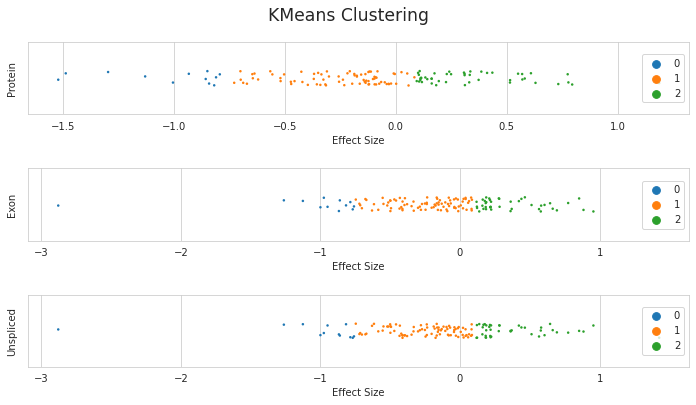

In [7]:
df = _df_protein.copy()

df = df.sample(frac=.025, random_state=RANDOM_STATE)

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Protein'] = ''

_df_protein_strip_plot = df.copy()



df = _df_exon.copy()

df = df.sample(frac=.025, random_state=RANDOM_STATE)

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Exon'] = ''

_df_exon_strip_plot = df.copy()



df = _df_unspliced.copy()

df = df.sample(frac=.025, random_state=RANDOM_STATE)

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Unspliced'] = ''

_df_unspliced_strip_plot = df.copy()



sns.set_style('whitegrid')

fig, (ax1, ax2, ax3) = plt.subplots(3,1)

fig.suptitle('KMeans Clustering', fontsize='xx-large')
fig.set_size_inches((10,5.5))
fig.tight_layout()

_ = sns.stripplot(data=_df_protein_strip_plot, x='Effect Size', y='Protein', hue="Class", marker='.', jitter=True,  ax=ax1)
_= ax1.legend(loc='right')
_ = sns.stripplot(data=_df_exon_strip_plot, x='Effect Size', y='Exon', hue="Class", marker='.', jitter=True,  ax=ax2)
_= ax2.legend(loc='right')
_ = sns.stripplot(data=_df_unspliced_strip_plot, x='Effect Size', y='Unspliced', hue="Class", marker='.', jitter=True,  ax=ax3)
_= ax3.legend(loc='right')

plt.subplots_adjust(wspace=0.3, hspace=0.75)

In [8]:
def feature_density(df, ngram_range):

    tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=ngram_range)

    X = tfidf.fit_transform(df['sequence'].tolist())

    X = X.todense()

    df = pd.DataFrame(X, columns=tfidf.get_feature_names_out())

    df = df.T.copy()

    kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit(df.to_numpy())

    df['Class'] = kmeans.labels_

    print(pd.Series(kmeans.labels_).value_counts())

    df = df.groupby(['Class']).apply(lambda x: ((x != 0).sum().sum()/(x.shape[0] * x.shape[1]), x.index.tolist())).to_frame(name='density_features').reset_index()

    df['Density'] = df.apply(lambda x: x['density_features'][0], axis=1)

    df['Features'] = df.apply(lambda x: x['density_features'][1], axis=1)

    df['Count'] = df['Features'].apply(lambda x: len(x))

    df = df.drop(['density_features'], axis=1)

    return df.copy()

In [9]:
_df_protein_features = feature_density(df=_df_protein.copy(), ngram_range=(4,4))

0    143923
2     23026
1         1
dtype: int64


In [10]:
_df_exon_features = feature_density(df=_df_exon.copy(), ngram_range=(10,10))

In [ ]:
_df_unspliced_features = feature_density(df=_df_unspliced.sample(frac=.1, random_state=RANDOM_STATE).copy(), ngram_range=(12,12))

In [ ]:
sns.set_style('white')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.suptitle('Feature Density Analysis', fontsize='xx-large')
fig.set_size_inches((20,5))
fig.subplots_adjust(top=.85)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.barplot(data=_df_protein_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax1)
ax1.set_yscale("log")
ax1.set_title('Protein Feature Density')
ax1_twin = ax1.twinx()
sns.lineplot(data=_df_protein_features, x='Class', y='Density', marker='o', label='Density', sort=False, ax=ax1_twin)
_= ax1_twin.legend(loc='upper right')

sns.barplot(data=_df_exon_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax2)
ax2.set_yscale("log")
ax2.set_title('Exon Feature Density')
ax2_twin = ax2.twinx()
sns.lineplot(data=_df_exon_features, x='Class', y='Density', marker='o', label='Density', sort = False, ax=ax2_twin)
_= ax2_twin.legend(loc='upper right')

sns.barplot(data=_df_unspliced_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax3)
ax3.set_yscale("log")
ax3.set_title('Unspliced Feature Density')
ax3_twin = ax3.twinx()
sns.lineplot(data=_df_unspliced_features, x='Class', y='Density', marker='o', label='Density', sort = False, ax=ax3_twin)
_= ax3_twin.legend(loc='upper right')

In [ ]:
df = _df_protein_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

protein_vocabulary = df['Features'].sum()



df = _df_exon_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

exon_vocabulary = df['Features'].sum()



df = _df_unspliced_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

unspliced_vocabulary = df['Features'].sum()

In [ ]:
def process(_df, ngram_range):

    X = _df['sequence'].copy().to_numpy()
    y = _df['class'].copy().to_numpy()

    dfs = []

    param_grid = {
        'tfidfVectorizer__ngram_range': [ngram_range],
        'tfidfVectorizer__norm': ('l1', 'l2'),
        'SVC__kernel': ['linear', 'rbf'],
        'SVC__C': [0.001,0.01,0.1,1,10,100, 1000],
        'SVC__gamma': ['scale', 'auto']
    }

    pipe = Pipeline(steps=[
        ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=protein_vocabulary)),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('SVC', SVC())
        ])

    gsSVC = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=3, verbose=3)

    gsSVC.fit(X, y)

    df = pd.DataFrame(gsSVC.cv_results_)

    df['classifier'] = 'SVC'

    dfs.append(df)



    X = _df['sequence'].copy().to_numpy()
    y = _df['class'].copy().to_numpy()
    
    param_grid = {
        'tfidfVectorizer__ngram_range': [(4, 4)],
        'dummyClassifier__strategy': ['uniform', 'most_frequent']
    }

    pipe = Pipeline(steps=[
        ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb')), 
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('dummyClassifier', DummyClassifier())
        ])

    gsDummyClassifier = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=2, verbose=3)

    gsDummyClassifier.fit(X, y)

    df = pd.DataFrame(gsDummyClassifier.cv_results_)

    df['classifier'] = 'DummyClassifier'

    dfs.append(df)

    df = pd.concat(dfs)

    df = df.set_index(['classifier'])

    df = df.reset_index(drop=True)

    return df.copy()

In [ ]:
df = _df_protein.copy()

df = process(df, (4,4))

df.to_pickle(f'classification_protein_{RANDOM_STATE}.pkl')

In [ ]:
df = _df_exon.copy()

df = process(df, (10,10))

df.to_pickle(f'classification_exon_{RANDOM_STATE}.pkl')

In [ ]:
df = _df_unspliced.copy()

df = process(df, (12,12))

df.to_pickle(f'classification_unspliced_{RANDOM_STATE}.pkl')

In [ ]:
df = pd.read_pickle(f'classification_protein_{RANDOM_STATE}.pkl')

df.groupby(['classifier']).apply(lambda x: x.loc[x['mean_test_score'] == x['mean_test_score'].max()])

In [ ]:
# param_grid = {
#     'tfidfVectorizer__ngram_range': [(4, 4)],
#     'tfidfVectorizer__norm': ('l1', 'l2'),
#     'logisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# }

# pipe = Pipeline(steps=[
#     ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb')), 
#     ('logisticRegression', LogisticRegression())
#     ])

# gsLogisticRegression = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=2, verbose=3)

# gsLogisticRegression.fit(X, y)

In [ ]:
# df = pd.DataFrame(gsLogisticRegression.cv_results_)

# df.loc[df['mean_test_score'] == df['mean_test_score'].max()]